# Figure 1cd Reproduction Notebook
This notebook reproduces the figures 1c and 1d from pre-generated CSV data. 

### 1. Imports and Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
from statsmodels.stats.multitest import multipletests

### 2. Plotting and Statistical Helper Functions

In [5]:
def apply_matplotlib_settings():
    """Applies the specified matplotlib settings for the plot."""
    settings = {
        "text.usetex": False, "mathtext.default": "regular", "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans", "Arial", "sans-serif"], "font.size": 7,
        "figure.titlesize": 7, "legend.fontsize": 7, "axes.titlesize": 7,
        "axes.labelsize": 7, "xtick.labelsize": 7, "ytick.labelsize": 7,
        "image.interpolation": "nearest", "image.resample": False, "axes.spines.left": True,
        "axes.spines.bottom": True, "axes.spines.top": False, "axes.spines.right": False,
        "axes.linewidth": 0.7, "xtick.major.width": 0.7, "ytick.major.width": 0.7,
        "lines.linewidth": 1.5, "lines.markersize": 3, "savefig.dpi": 300,
        "figure.dpi": 150, "savefig.format": "svg", "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1, "svg.fonttype": "none", "legend.frameon": False,
        "pdf.fonttype": 42,
    }
    plt.rcParams.update(settings)

def darken_color(hex_color, factor=0.7):
    """Darken a hex color by the given factor"""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * factor) for c in rgb)
    return f"#{darkened_rgb[0]:02x}{darkened_rgb[1]:02x}{darkened_rgb[2]:02x}"

def perform_statistical_tests_calibration(data_df):
    """
    Performs one-sided paired t-tests with Benjamini-Hochberg correction for calibration data.
    Tests if PRE-FT is significantly better than other conditions.
    """
    conditions, ref_condition = data_df['condition'].unique(), 'PRE-FT'
    if ref_condition not in conditions: return {}
    
    ref_data_all = data_df[(data_df['condition'] == ref_condition) & (data_df['variant'] == 'All')]['roc_auc'].values
    ref_data_extreme = data_df[(data_df['condition'] == ref_condition) & (data_df['variant'] == 'Extreme')]['roc_auc'].values
    
    p_values, test_results = [], {}
    for condition in conditions:
        if condition == ref_condition: continue
        cond_data_all = data_df[(data_df['condition'] == condition) & (data_df['variant'] == 'All')]['roc_auc'].values
        cond_data_extreme = data_df[(data_df['condition'] == condition) & (data_df['variant'] == 'Extreme')]['roc_auc'].values
        
        _, p_all = stats.ttest_rel(ref_data_all, cond_data_all, alternative='greater')
        _, p_extreme = stats.ttest_rel(ref_data_extreme, cond_data_extreme, alternative='greater')
        
        p_values.extend([p_all, p_extreme])
        test_results[condition] = {'all': p_all, 'extreme': p_extreme}
    
    if p_values:
        _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        p_idx = 0
        for condition in conditions:
            if condition == ref_condition: continue
            test_results[condition]['all_corrected'] = p_corrected[p_idx]
            test_results[condition]['extreme_corrected'] = p_corrected[p_idx + 1]
            p_idx += 2
    return test_results

def get_significance_stars(p_value):
    """Convert p-value to significance stars."""
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    return ''

### 3. Core Plotting Functions

In [6]:
def plot_roc_over_time_from_csv(ax, csv_path, colors, x_lims):
    """Plots ROC-AUC over a sliding window from a pre-calculated CSV file."""
    data_df = pd.read_csv(csv_path)
    labels = data_df['condition'].unique()

    for label in labels:
        color = colors.get(label, 'k')
        condition_df = data_df[data_df['condition'] == label]
        ax.plot(condition_df['trial_index'], condition_df['median_roc_auc'], label=label, color=color, linewidth=1)
        ax.fill_between(condition_df['trial_index'], condition_df['lower_quantile_roc_auc'], condition_df['upper_quantile_roc_auc'], alpha=0.2, color=color)

    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    ax.set_xlabel('Trial index')
    ax.set_ylabel('ROC-AUC')
    ax.legend(loc='lower right')
    ax.set_ylim(0.3, 0.9)
    ax.set_xlim(left=x_lims[0], right=x_lims[1])

def plot_calibration_violins_from_csv(ax, csv_path):
    """Creates grouped violin plots for calibration results from a processed CSV file."""
    df_combined = pd.read_csv(csv_path)

    condition_order = ['SS-CAL', 'SS-FT', 'PRE-ZS', 'PRE-CAL', 'PRE-FT']
    colors_all = {'PRE-FT': '#80a687', **{c: '#9e9e9e' for c in condition_order if c != 'PRE-FT'}}
    colors_extreme = {'PRE-FT': '#cee1d1', **{c: '#e1e1e0' for c in condition_order if c != 'PRE-FT'}}

    df_combined['cat_variant'] = df_combined['condition'].astype(str) + '_' + df_combined['variant']
    plot_order = [f'{c}_{v}' for c in condition_order for v in ['All', 'Extreme']]
    
    position_mapping = {f'{c}_{v}': i*1.5 + (0 if v == 'All' else 0.4) for i, c in enumerate(condition_order) for v in ['All', 'Extreme']}
    palette_dict = {f'{c}_All': colors_all[c] for c in condition_order}
    palette_dict.update({f'{c}_Extreme': colors_extreme[c] for c in condition_order})
    edge_palette_dict = {k: darken_color(v) for k, v in palette_dict.items()}

    stat_results = perform_statistical_tests_calibration(df_combined)

    for cat_var in plot_order:
        data_subset = df_combined[df_combined['cat_variant'] == cat_var]
        if data_subset.empty: continue
        pos, color, edge_color = position_mapping[cat_var], palette_dict[cat_var], edge_palette_dict[cat_var]
        
        parts = ax.violinplot(dataset=data_subset['roc_auc'].dropna(), positions=[pos], showextrema=False, widths=0.4, bw_method=0.2)
        for pc in parts['bodies']:
            pc.set_facecolor(color); pc.set_edgecolor(edge_color); pc.set_linewidth(0.5); pc.set_alpha(1.0)
        
        ax.boxplot(x=data_subset['roc_auc'].dropna(), positions=[pos], vert=True, patch_artist=True, widths=0.2, showfliers=False,
                   whiskerprops={'color': edge_color, 'linewidth': 0.5}, capprops={'color': edge_color, 'linewidth': 0.5},
                   medianprops={'color': edge_color, 'linewidth': 0.8}, boxprops={'facecolor': 'w', 'edgecolor': edge_color, 'linewidth': 0.5})

    y_max = ax.get_ylim()[1]
    for cat_var in plot_order:
        condition, variant = cat_var.rsplit('_', 1)
        if condition in stat_results:
            p_key = 'all_corrected' if variant == 'All' else 'extreme_corrected'
            stars = get_significance_stars(stat_results[condition].get(p_key, 1))
            if stars: ax.text(position_mapping[cat_var], y_max - 0.02, stars, ha='center', va='top', fontsize=6, fontweight='bold')

    ax.set_xticks([i * 1.5 + 0.2 for i in range(len(condition_order))])
    ax.set_xticklabels(condition_order, ha="right")
    ax.tick_params(axis='x', length=3)
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    ax.set_ylabel('ROC-AUC')
    ax.set_ylim(0.4, 1.0)
    ax.legend(handles=[Patch(facecolor='#555555', label='All'), Patch(facecolor='#CCCCCC', label='Extreme')], loc='lower right', handlelength=1)
    
    print("Statistical test results for calibration:")
    for cond, res in stat_results.items():
        if 'all_corrected' in res: print(f"  {cond}: All p={res['all_corrected']:.4f}, Extreme p={res['extreme_corrected']:.4f}")


### 4. Main Execution Block

--- Generating Plot 1: ROC over Time ---
Plot 1 saved to TMSEEG_roc_over_time.pdf

--- Generating Plot 2: Calibration Violins ---
Statistical test results for calibration:
  PRE-ZS: All p=0.0000, Extreme p=0.0000
  PRE-CAL: All p=0.0048, Extreme p=0.0024
  SS-CAL: All p=0.0000, Extreme p=0.0000
  SS-FT: All p=0.0000, Extreme p=0.0000

Plot 2 saved to TMSEEG_calibration_violins.pdf



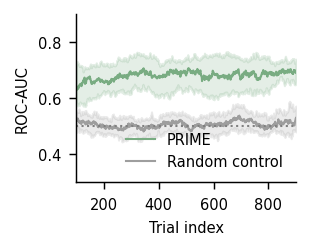

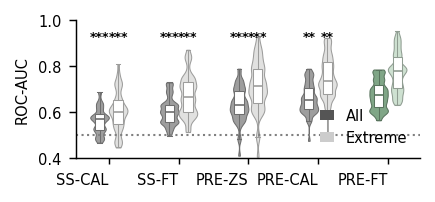

In [7]:
# Define paths to the pre-generated data files
DATA_DIR = "reproduction_data"
CSV_ROC = os.path.join(DATA_DIR, "roc_over_time_data.csv")
CSV_CALIBRATION = os.path.join(DATA_DIR, "calibration_data.csv")
CSV_SCATTER = os.path.join(DATA_DIR, "predicted_vs_actual_data.csv")

# Apply global plot settings
apply_matplotlib_settings()

# --- Plot 1: ROC over Time (Sliding Window) ---
print("--- Generating Plot 1: ROC over Time ---")
fig1, ax1 = plt.subplots(figsize=(1.97, 1.57))
plot_roc_over_time_from_csv(
    ax=ax1,
    csv_path=CSV_ROC,
    colors={'PRIME': '#79ac82', 'Random control': '#9e9e9e'},
    x_lims=(100, 900)
)
fig1.tight_layout(pad=0.5)
plt.savefig("TMSEEG_roc_over_time.pdf")
print("Plot 1 saved to TMSEEG_roc_over_time.pdf\n")

# --- Plot 2: Calibration and Fine-Tuning Violins ---
print("--- Generating Plot 2: Calibration Violins ---")
fig2, ax2 = plt.subplots(figsize=(2.8, 1.25))
plot_calibration_violins_from_csv(ax2, CSV_CALIBRATION)
fig2.tight_layout(pad=0.5)
plt.savefig("TMSEEG_calibration_violins.pdf")
print("\nPlot 2 saved to TMSEEG_calibration_violins.pdf\n")

plt.show()